# Interactive loading of PHEONIX NewEra synthetic stellar spectra
Model grids published in The NewEra model grid ([Hauschildt _et al_., 2025](https://ui.adsabs.harvard.edu/abs/2025arXiv250417597H))

Data and sample code published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156)

In [1]:
from pathlib import Path
from io import StringIO

import numpy as np
#%matplotlib widget 
import matplotlib.pyplot as plt
import astropy.units as u

from deblib.constants import c

/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


### Parse the SPECTRA text file
The data files are in the [PHOENIX-NewEra-LowRes-SPECTRA.tar.gz](https://www.fdr.uni-hamburg.de/record/17156/files/PHOENIX-NewEra-LowRes-SPECTRA.tar.gz?download=1)
archive published at [DOI: 10.25592/uhhfdm.16727](https://doi.org/10.25592/uhhfdm.17156).

> **Note**: the archive is ~17.7 GB is size

In [2]:
# These are prepared "low res" spectra covering the range 250 to 2500 nm in 0.01 nm steps.
Z = 0.0
filename = Path(f'./libs/data/newera/PHOENIX-NewEra-LowRes-SPECTRA.Z-{Z:.1f}.txt')

In [3]:
def iterate_text_file(filename, encoding="utf8", skip=0, step=1):
    """
    Creates a generator, iterating over the lines in the passed text file.
    The skip argument indicates to skip the first n lines.
    The step argument indicates to yield every nth line after any initial skip.
    """
    with open(filename, "r", encoding=encoding) as f:
        for ix, line in enumerate(f):
            if ix >= skip and (ix-skip) % step == 0:
                yield line.rstrip()

def iterate_spectra_file(filename, skip=0):
    """
    Creates a generator which iterates over a PHOENIX NewEra low res spectra text file
    two lines at a time, yielding the fields line and flux line separately.
    """
    field_line, flux_line = None, None
    for count, line in enumerate(iterate_text_file(filename, "utf8", skip=skip)):
        if count % 2 == 0:
            field_line = line
        else:
            flux_line = line
            yield field_line, flux_line

In [4]:
dtype = [(p, float) for p in ["teff", "logg", "mass"]]
crit = np.genfromtxt(iterate_text_file(filename, step=2), dtype=dtype, usecols=[12, 13, 27])
spec_count = len(crit)
del crit

Parse the text data file into a `numpy` structured array.

At this point we are also reducing the resolution of the spectra by a factor of 1000, from the ${\rm nm}$ to $\mu{\rm m}$ scale bins.

In [5]:
# Mappings for the columns in text file to named fields in a numpy structured array
fields_index = { "teff": 12, "logg": 13, "mass": 27, "lam_steps": 8, "lam_from": 9, "lam_to": 10, "lam_step": 11 }
fields_names = list(fields_index.keys())
fields_cols = [fields_index[n] for n in fields_names]
fields_dtype = [(n, int if n == "lam_steps" else float) for n in fields_names]

table_dtype = fields_dtype + [("flux", object)]
table = np.empty((spec_count, ), dtype=table_dtype)

# Parse the text file (with fields and fluxes on separate contiguous lines) into a table
row_num = 0
for field_line, flux_line in iterate_spectra_file(filename):
    if len(field_line) and len(flux_line):
        fields = np.loadtxt(StringIO(field_line), dtype=fields_dtype, usecols=fields_cols)
        fluxes = np.loadtxt(StringIO(flux_line), dtype=np.dtype(float), unpack=True)
        
        # Reduce the resolution of the spectrum by a factor of 1000 (from nm to um ramge)
        lambdas = np.linspace(fields["lam_from"], fields["lam_to"], len(fluxes))        # nm
        low_cents = np.arange(1e3, len(lambdas), 1e3, dtype=int)[:-1]
        low_flux = np.array([np.sum(fluxes[cent-499:cent+499]) for cent in low_cents])  # binning
        #low_flux = np.array([np.sum(fluxes[cent]) for cent in low_cents])               # not-binning

        # Revise the metadata to reflect the reduction in spectral resolution and change
        # the lambdas from nm to um (rescaling leaves the step size scalar value unchanged).
        fields["lam_steps"] = len(low_flux)
        fields["lam_from"] = lambdas[low_cents[0]] / 1e3                                # nm to um
        fields["lam_to"] = lambdas[low_cents[-1]] / 1e3                                 # nm to um

        # Store this row
        for fn in fields_names:
            table[row_num][fn] = fields[fn]
        table[row_num]["flux"] = low_flux
        row_num += 1

### Query the Spectra table

In [6]:
target_teff = 5770  # K
target_logg = 4.4

print(f"Looking for spectra for T_eff = {target_teff} K and logg = {target_logg}")
for ix, row in enumerate(table):
    teff, logg, mass = row[["teff", "logg", "mass"]]

    # Looking for close, but not necessarily exact, match.
    if np.round(teff/100) == np.round(target_teff/100) and np.round(logg*10) == np.round(target_logg*10):
        print(f"Row {ix} selected with T_eff = {teff} K and logg = {logg} (& mass = {mass} M_Sun)")

        fluxes = row["flux"]
        lambdas = np.linspace(row["lam_from"], row["lam_to"], len(fluxes))
        break

Looking for spectra for T_eff = 5770 K and logg = 4.4
Row 457 selected with T_eff = 5770.0 K and logg = 4.44 (& mass = 1.0 M_Sun)


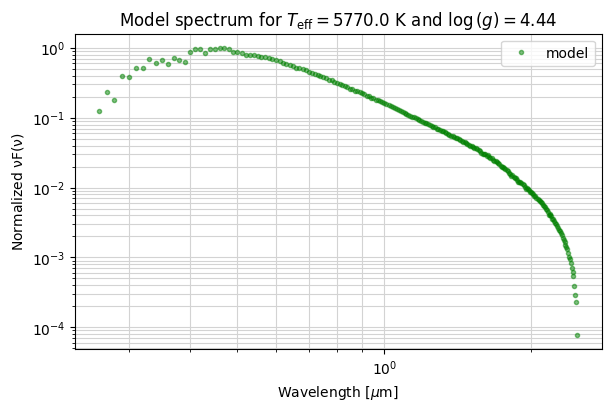

In [7]:
vfv = fluxes * c / (lambdas * 1e6)
norm_vfv = (vfv - vfv.min()) / (vfv.max() - vfv.min())

title = f"Model spectrum for $T_{{\\rm eff}}={teff}$ K and $\\log{{(g)}}={logg}$"
fig, ax = plt.subplots(1, 1, figsize=(6, 4), constrained_layout=True)
ax.loglog(lambdas, norm_vfv, ".g", alpha=0.5, label="model")
ax.set(title=title, xlabel=r"Wavelength [$\mu$m]", ylabel=r"Normalized ${\rm \nu F(\nu)}$")
ax.grid(True, which="both", axis="both", color="lightgray")
ax.legend(loc="best")
plt.show(fig)
plt.close(fig)